### Практика

### Case 1

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [30]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
data = "/churn_data.csv"

In [33]:
df = pd.read_csv(data)
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [34]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

Зададим списки признаков

In [36]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [126]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [127]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [128]:
from sklearn.ensemble import RandomForestClassifier

pipeline_RF = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [129]:
from sklearn.ensemble import GradientBoostingClassifier
pipeline_GB = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [130]:
from sklearn.linear_model import LogisticRegression
pipeline_LR = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

Обучим модель

In [131]:
pipeline_LR.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [132]:
pipeline_GB.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [133]:
#обучим наш пайплайн
pipeline_RF.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [233]:
#наши прогнозы для тестовой выборки
compare_mods = {'model': [], 'f-score':[], 'precision':[], 'recall':[] }
preds_LR = pipeline_LR.predict_proba(X_test)[:, 1]
preds_GB = pipeline_GB.predict_proba(X_test)[:, 1]
preds_RF = pipeline_RF.predict_proba(X_test)[:, 1]
compare_mods['model'].append('Logistic Regression')
compare_mods['model'].append('Gradient Boosting')
compare_mods['model'].append('Random Forest')
print(compare_mods)




{'model': ['Logistic Regression', 'Gradient Boosting', 'Random Forest'], 'f-score': [], 'precision': [], 'recall': []}


Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [135]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [211]:
def pres_rec(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    return thresholds[ix], fscore[ix], precision[ix], recall[ix]

In [234]:
thresholds_LR, fscore_LR, precision_LR, recall_LR = pres_rec(y_test, preds_LR)
compare_mods['f-score'].append(fscore_LR)
compare_mods['precision'].append(precision_LR)
compare_mods['recall'].append(recall_LR)

In [235]:
thresholds_GB, fscore_GB, precision_GB, recall_GB = pres_rec(y_test, preds_GB)
compare_mods['f-score'].append(fscore_GB)
compare_mods['precision'].append(precision_GB)
compare_mods['recall'].append(recall_GB)
print(compare_mods)

{'model': ['Logistic Regression', 'Gradient Boosting', 'Random Forest'], 'f-score': [0.5097001763668431, 0.6461211477151967], 'precision': [0.4624, 0.7037037037037037], 'recall': [0.5677799607072691, 0.5972495088408645]}


In [236]:
thresholds_RF, fscore_RF, precision_RF, recall_RF = pres_rec(y_test, preds_RF)
compare_mods['f-score'].append(fscore_RF)
compare_mods['precision'].append(precision_RF)
compare_mods['recall'].append(recall_RF)
print(compare_mods)

{'model': ['Logistic Regression', 'Gradient Boosting', 'Random Forest'], 'f-score': [0.5097001763668431, 0.6461211477151967, 0.6412825651302605], 'precision': [0.4624, 0.7037037037037037, 0.65439672801636], 'recall': [0.5677799607072691, 0.5972495088408645, 0.6286836935166994]}


In [216]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


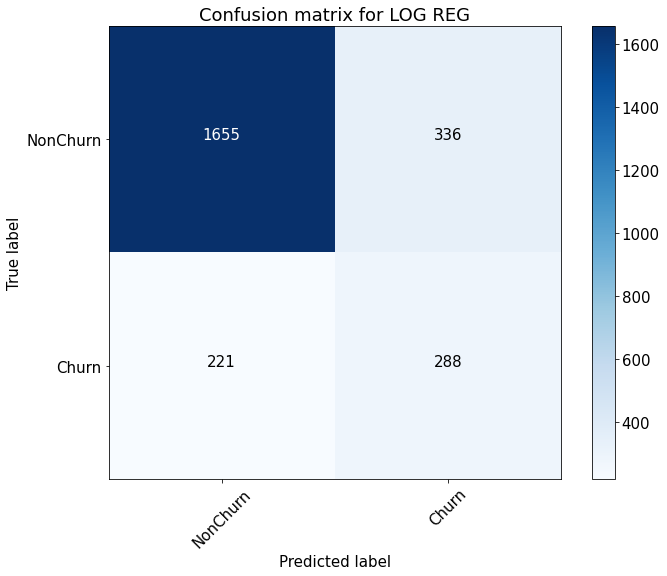

In [217]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_LR = confusion_matrix(y_test, preds_LR>thresholds_LR)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_LR, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix for LOG REG')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


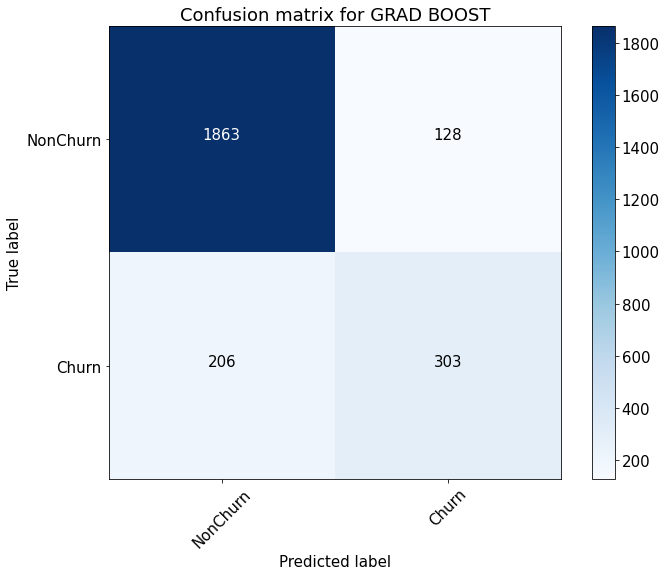

In [218]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_GB = confusion_matrix(y_test, preds_GB>thresholds_GB)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_GB, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix for GRAD BOOST')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


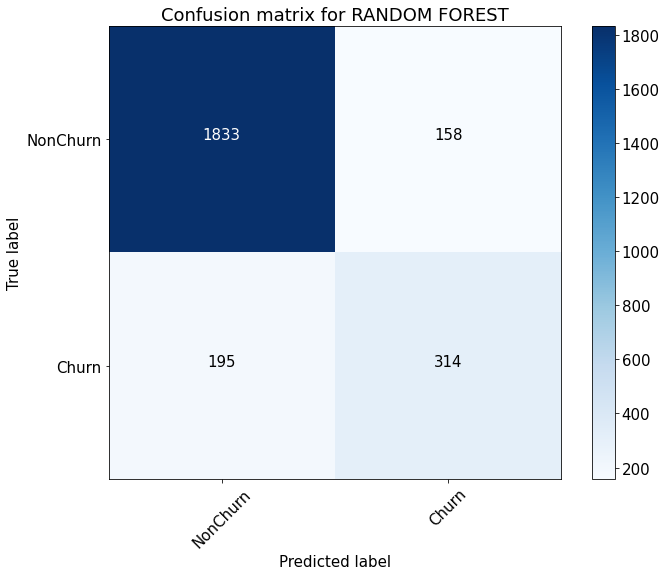

In [220]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_RF = confusion_matrix(y_test, preds_RF>thresholds_RF)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_RF, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix for RANDOM FOREST')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

In [224]:
TN = cnf_matrix_GB[0][0]
FN = cnf_matrix_GB[1][0]
TP = cnf_matrix_GB[1][1]
FP = cnf_matrix_GB[0][1]
income = TP*2
outcome = (TP+FP)*1
print(income-outcome)

175


In [225]:
TN = cnf_matrix_RF[0][0]
FN = cnf_matrix_RF[1][0]
TP = cnf_matrix_RF[1][1]
FP = cnf_matrix_RF[0][1]
income = TP*2
outcome = (TP+FP)*1
print(income-outcome)

156


In [226]:
TN = cnf_matrix_LR[0][0]
FN = cnf_matrix_LR[1][0]
TP = cnf_matrix_LR[1][1]
FP = cnf_matrix_LR[0][1]
income = TP*2
outcome = (TP+FP)*1
print(income-outcome)

-48


<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

### Пример с перебором параметров с помощью GridSearch

Сетка с параметрами

In [184]:
from sklearn.model_selection import GridSearchCV

params={'classifier__n_estimators':[10, 100, 1000],
        'classifier__min_samples_leaf':[1, 2, 3],
        }

Запускаем перебор

In [185]:
grid = GridSearchCV(pipeline_GB,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100}

Обучаем модель уже сновыми параметрами

In [186]:
pipeline_GB_opt = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(min_samples_leaf=2, random_state=42)),
])
pipeline_GB_opt.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.355052, F-Score=0.645, Precision=0.653, Recall=0.637
Confusion matrix, without normalization
[[1819  172]
 [ 186  323]]


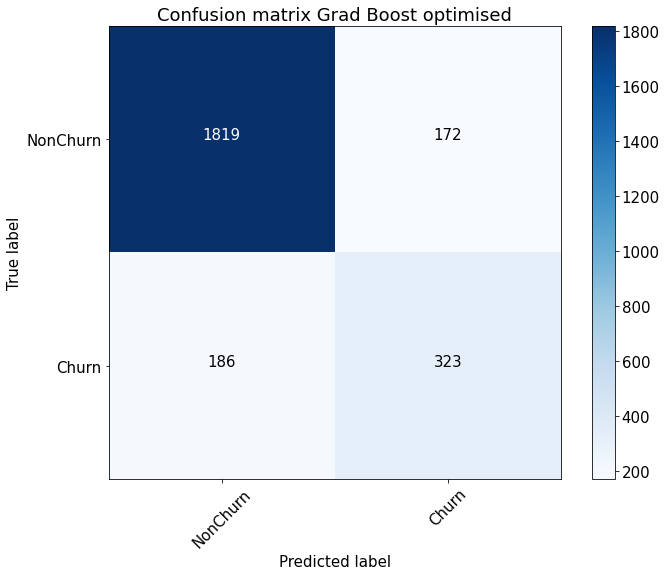

In [227]:
preds_opt = pipeline_GB_opt.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds_opt)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_opt>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix Grad Boost optimised')
plt.savefig("conf_matrix.png")
plt.show()

Метрики немного стали выше

In [228]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
income = TP*2
outcome = (TP+FP)*1
print(income-outcome)

151


In [241]:
compare_mods['model'].pop(-1)
compare_mods['f-score'].pop(-1)
compare_mods['precision'].pop(-1)
compare_mods['recall'].pop(-1)

array([1.        , 0.99803536, 0.99803536, ..., 0.00392927, 0.00196464,
       0.        ])

In [242]:
compare_mods['model'].append('Grad_Boost_Optimised')
compare_mods['f-score'].append(fscore[ix])
compare_mods['precision'].append(precision[ix])
compare_mods['recall'].append(recall[ix])

In [243]:
print(compare_mods)

{'model': ['Logistic Regression', 'Gradient Boosting', 'Random Forest', 'Grad_Boost_Optimised'], 'f-score': [0.5097001763668431, 0.6461211477151967, 0.6412825651302605, 0.6447761194029852], 'precision': [0.4624, 0.7037037037037037, 0.65439672801636, 0.6532258064516129], 'recall': [0.5677799607072691, 0.5972495088408645, 0.6286836935166994, 0.6365422396856582]}


In [244]:
pd.DataFrame(data=compare_mods).sort_values('precision', ascending=False)

,model,f-score,precision,recall
1,Gradient Boosting,0.646121,0.703704,0.597250
2,Random Forest,0.641283,0.654397,0.628684
3,Grad_Boost_Optimised,0.644776,0.653226,0.636542
0,Logistic Regression,0.509700,0.462400,0.567780
